# Kidney 3 EDA

In [1]:
import torch
from PIL import Image
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from surface_dice import SurfaceDiceMetric
import albumentations as A
from IPython.display import clear_output
import random
import segmentation_models_pytorch as smp
from patcher import Patcher

hostname = os.uname().nodename
print("Hostname:", hostname)
input_dir = "data/blood-vessel-segmentation/" if hostname == "gamma" else "/kaggle/input/blood-vessel-segmentation/"


device = "cuda" if torch.cuda.is_available() else "cpu"
train_dir = input_dir + "train/"

# reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Hostname: 60c14e421bc7


In [2]:
input_dir = "/kaggle/input/blood-vessel-segmentation/"
train_dir = input_dir + "train/"
dense_dir = train_dir + "kidney_3_dense/"
sparse_dir = train_dir + "kidney_3_sparse/"

imgs_ids = sorted(os.listdir(sparse_dir + "images"))
dense_msks_ids = sorted(os.listdir(dense_dir + "labels"))
sparse_msks_ids = sorted(os.listdir(sparse_dir + "labels"))

print("Number of images:", len(imgs_ids))
print("Number of dense masks:", len(dense_msks_ids))
print("Number of sparse masks:", len(sparse_msks_ids))

Number of images: 1035
Number of dense masks: 501
Number of sparse masks: 1035


In [ ]:
print(dense_msks_ids[:10])
print(sparse_msks_ids[:10])

### ¿Are the images with dense masks a subset of the images with sparse masks?

Yes.

In [ ]:
sorted(list(set(dense_msks_ids) & set(sparse_msks_ids))) == dense_msks_ids


In [ ]:
idx = torch.randint(len(dense_msks_ids), (1,)).item()


img1 = np.array(Image.open(sparse_dir + "labels/" + dense_msks_ids[idx]))
img2 = np.array(Image.open(dense_dir + "labels/" + dense_msks_ids[idx]))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

print(f"Image ID: {idx + 496}")
axs[0].imshow(img1)
axs[0].set_title("Sparse mask")
axs[1].imshow(img2)
axs[1].set_title("Dense mask")
plt.show()


### Comparison between sparse and dense labels using Surface Dice metric

In [ ]:
class ComparisonDataset(torch.utils.data.Dataset):
    def __init__(self, dir1, dir2, ids):
        self.dir1 = dir1
        self.dir2 = dir2
        self.ids = ids

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img1_path = self.dir1 + self.ids[idx]
        img2_path = self.dir2 + self.ids[idx]
        
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        img1 = torch.as_tensor(np.array(img1) / 255, dtype=torch.uint8)
        img2 = torch.as_tensor(np.array(img2) / 255, dtype=torch.uint8)

        return img1, img2

In [ ]:
ds = ComparisonDataset(sparse_dir + "labels/", dense_dir + "labels/", dense_msks_ids)
dl = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=False, num_workers=os.cpu_count())

In [ ]:
metric = SurfaceDiceMetric(len(dl), device)

for imgs1, imgs2 in tqdm(dl):
    imgs1, imgs2 = imgs1.to(device), imgs2.to(device)
    metric.process_batch(imgs1, imgs2)

dice = metric.compute()

dice

### Looking at the images

In [3]:
class KidneyDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_dir, msks_dir, slices_ids, transforms=None):
        self.imgs_dir = imgs_dir
        self.msks_dir = msks_dir
        self.slices_ids = slices_ids
        self.transforms = transforms
        self.h = Image.open(imgs_dir + slices_ids[0]).height
        self.w = Image.open(imgs_dir + slices_ids[0]).width

    def __len__(self):
        return len(self.slices_ids)

    def __getitem__(self, idx):
        slice_id = self.slices_ids[idx]
        img_path = self.imgs_dir + slice_id
        msk_path = self.msks_dir + slice_id

        img = np.array(Image.open(img_path), dtype=np.float32)
        img = torch.from_numpy(img)

        return img

In [4]:
ds = KidneyDataset(sparse_dir + "images/", sparse_dir + "labels/", sparse_msks_ids)
dl = DataLoader(ds, batch_size=len(ds), shuffle=False)

In [5]:
x = next(iter(dl))

In [6]:
x.shape

torch.Size([1035, 1706, 1510])

In [ ]:
d_dim = 2
if d_dim == 0:
    x_tr = x.numpy().astype(np.uint16)
else:
    x_tr = x.transpose(0, d_dim).numpy().astype(np.uint16)


for idx in range(0, len(x_tr), 20):
    plt.title(f"Slice {idx + 1} of {len(x_tr)}")
    plt.imshow(x_tr[idx])
    plt.axis("off")
    plt.show()
    clear_output(wait=True)



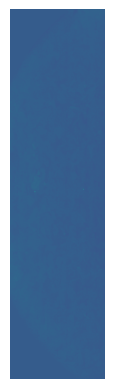

In [12]:
def make_digonal_slice(shape=[100,120,150]):#D, H, W
    D, H, W = shape

    S = max(H,W)
    L = min(H,W)
    L = int(0.25*((L**2+L**2)**0.5))

    x,y = np.arange(S), np.arange(S)

    #diag = np.stack([np.arange(S),np.arange(S)]) #shape (2, 150)
    #diagy = diag + np.stack([np.arange(S),np.zeros(S)])

    coord1=[]
    coord2=[]
    for h in range(H):
        xx = x
        yy = y+h
        valid = (yy>=0) & (yy<H) & (xx>=0) & (xx<W)
        if valid.sum()>L:
            yy1, xx1 =yy[valid], xx[valid]
            coord1.append([yy1, xx1])

            yy2 = yy1
            xx2 = W-1-xx1#np.ascontiguousarray(xx1[::-1])
            coord2.append([yy2, xx2])

    for w in range(1,W):
        xx = x+w
        yy = y
        valid = (yy>=0) & (yy<H) & (xx>=0) & (xx<W)
        if valid.sum()>L:
            yy1, xx1 =yy[valid], xx[valid]
            coord1.append([yy1, xx1])

            yy2 = yy1
            xx2 = W-1-xx1
            coord2.append([yy2, xx2])

    coord = coord1+coord2
    return coord


x1 = x.transpose(0, 2).numpy().astype(np.uint16)
D, H, W = x1.shape
coord = make_digonal_slice(shape=[D, H, W])


for idx in range(0, len(coord), 50):
    idx_y, idx_x = coord[idx]
    slice = x1[:, idx_y, idx_x]
    plt.imshow(slice)
    plt.axis("off")
    plt.show()
    clear_output(wait=True)